In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import os
from urllib.request import urlopen
import json
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.interpolate import griddata

from pygbif import occurrences as occ

Using the GBIF API to download iNaturalist data

Jillian: Time range / time series of species

Erica: spatial distribution of a species 
Kiran: Synthesizing iNaturalist data (counts of observations?)


In [2]:
sb_inat = pd.read_csv("/courses/EDS214/EDS220_gbffs/inat_sb_recent.csv", sep = '\t') #make sure to update the file path to where your data is stored

Spatial distribution of observations:

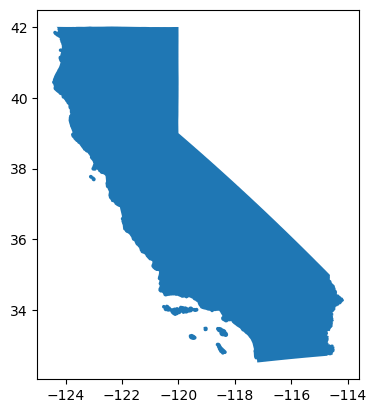

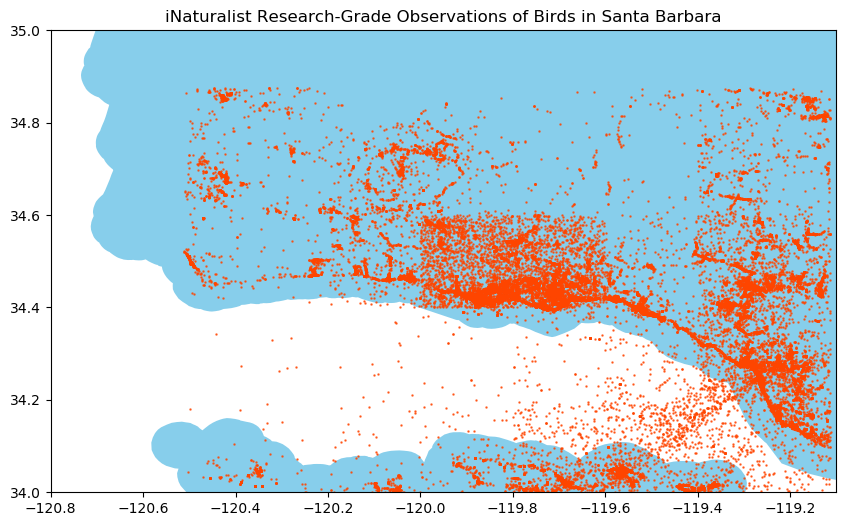

In [8]:
#setting up shp file path for CA state boundary (found online - https://data.ca.gov/dataset/ca-geographic-boundaries/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b)
shp_data = gpd.read_file("/courses/EDS214/EDS220_gbffs/ca-state-boundary/CA_State_TIGER2016.shp")


#now we want to isolate our table to only observations of class 'Aves'
sb_animals = sb_inat.loc[sb_inat['kingdom'] == "Animalia"] # filter data to just animal observations
sb_animals = gpd.GeoDataFrame(sb_animals)

#need to convert coordinates into actual coordinates, not just data points
obs_coords = gpd.points_from_xy(sb_animals['decimalLongitude'], sb_animals['decimalLatitude'], crs = "EPSG:4326")


sb_animals_gdf = gpd.GeoDataFrame(sb_animals, geometry=obs_coords)
sb_animals_gdf

#need to convert shp file into a lat/lon situation instead of meters
shp_reproj = shp_data.to_crs("epsg:4326") 
shp_reproj.plot()

#defining size of output figure
fig, ax = plt.subplots(figsize=(14,6))

#setting boundaries
xmin = -120.8
xmax = -119.1
ymin = 34
ymax = 35

#feed min and max thru into limits for x and y axis
xlim = (xmin, xmax)
ylim = (ymin, ymax)

#set axis to x and y limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

#sb map
plt.title("iNaturalist Research-Grade Observations of Birds in Santa Barbara")
shp_reproj.plot(legend = False, ax = ax,
               color = "skyblue")

#sb aves 
sb_animals_gdf.plot(aspect = 1,
               color = "orangered",
                marker = "o",
                 alpha = 0.75,
                 markersize = 0.6,
               ax = ax)

In [4]:
import shapely 
import geopandas as gpd
import pandas as pd

# Repeated--- read in the data! 
sb_inat = pd.read_csv("/courses/EDS214/EDS220_gbffs/inat_sb_recent.csv", sep = '\t') #make sure to update the file path to where your data is stored


sb_animals = sb_inat.loc[sb_inat['kingdom'] == "Animalia"] # filter data to just animal observations

In [34]:
# Using shapely, create geometries from your lat-lons
geom_list = [shapely.geometry.Point(lon,lat) for lon,lat in zip(tarantulas["decimalLongitude"] , tarantulas["decimalLatitude"])] # check the ordering of lon/lat

# Create a GeoDataFrame with a point at Bren Hall. 
# Start with a DataFrame...
ucsb_df = pd.DataFrame(
    {'Location': ['Bren Hall'],
     'Latitude': [34.413059],
     'Longitude': [-119.841826]})

# Then use that DataFrame to make a GeoDataFrame
ucsb_gdf = gpd.GeoDataFrame(
    ucsb_df, geometry=gpd.points_from_xy(ucsb_df.Longitude, ucsb_df.Latitude), crs={"init":"EPSG:4326"})

# Reproject this GDF to the same CRS as tarantulas_rpj--- this will allow us to do calculations in meters.
ucsb_gdf = ucsb_gdf.to_crs("EPSG:6423")

# Create a buffer around Bren at 1 mile

ucsb_buffer_1mile = ucsb_gdf.buffer(1609).unary_union # in meters

not_friendly_neighbors = tarantulas_rpj["geometry"].intersection(ucsb_buffer_1mile)

# print all the nearby points
print(tarantulas_rpj[~not_friendly_neighbors.is_empty]) # Yay! No tarantulas within a mile! 


NameError: name 'tarantulas' is not defined

In [5]:
print(sb_inat.head())

       gbifID                            datasetKey  \
0  1703218988  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
1  2542877676  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
2  2236229147  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
3  2826332347  50c9509d-22c7-4a22-a47d-8c48425ef4a7   
4  2963805574  50c9509d-22c7-4a22-a47d-8c48425ef4a7   

                                        occurrenceID   kingdom        phylum  \
0   https://www.inaturalist.org/observations/8964710   Plantae  Tracheophyta   
1  https://www.inaturalist.org/observations/14123375   Plantae  Tracheophyta   
2  https://www.inaturalist.org/observations/22100520   Plantae  Tracheophyta   
3  https://www.inaturalist.org/observations/54560051  Animalia    Arthropoda   
4  https://www.inaturalist.org/observations/63292703  Animalia      Chordata   

           class          order       family        genus  \
0  Magnoliopsida        Rosales     Rosaceae  Heteromeles   
1  Magnoliopsida       Lamiales    Lamiaceae  Trichostema   
2  Ma

Investigate how many different users are in the Santa Barbara area



/opt/python/3.10.5/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 78218 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/python/3.10.5/lib/python3.10/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 78218 missing from current font.
  font.set_text(s, 0, flags=flags)


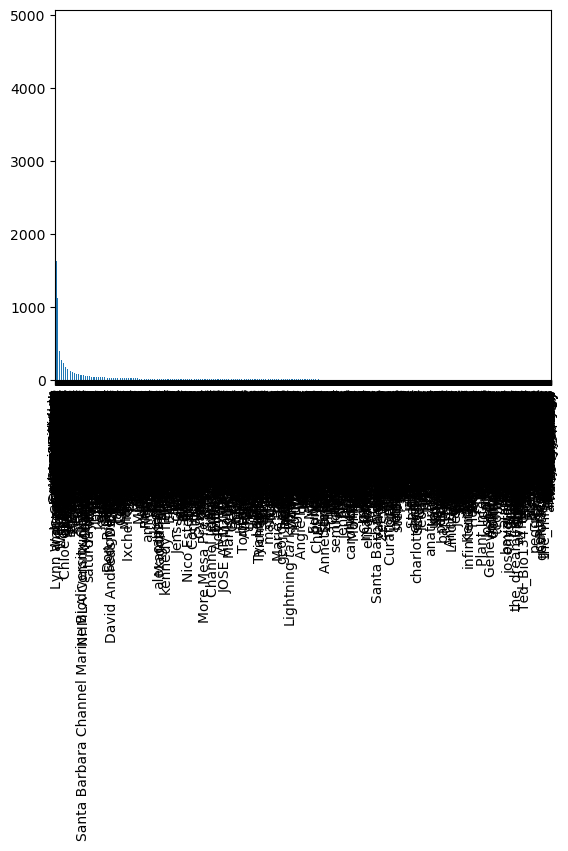

In [18]:
sb_inat.recordedBy.value_counts().plot(kind='bar') #this is really bad try a different way

In [7]:
len(sb_inat['recordedBy'].unique()) #There's 5,724 different users in SB!

5724

Text(0.5, 1.0, 'iNaturalist Users Recording Observations Around Santa Barbara')

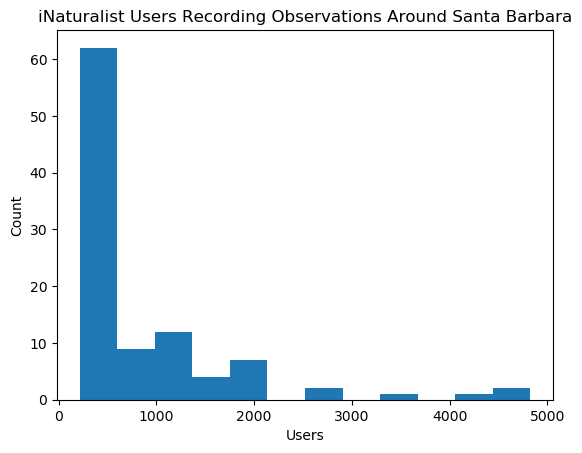

In [25]:
#How active are all of those users? - let's create a histogram to see how many observations are made by the top 100 users
n = 100
top_recorders = sb_inat.recordedBy.value_counts()[:n]

# set three variables, n, bins, and patches
n, bins, patches = plt.hist(x = top_recorders, bins='auto')

# Label plot axes
plt.xlabel('Users')
plt.ylabel('Count')
plt.title("iNaturalist Users Recording Observations Around Santa Barbara")


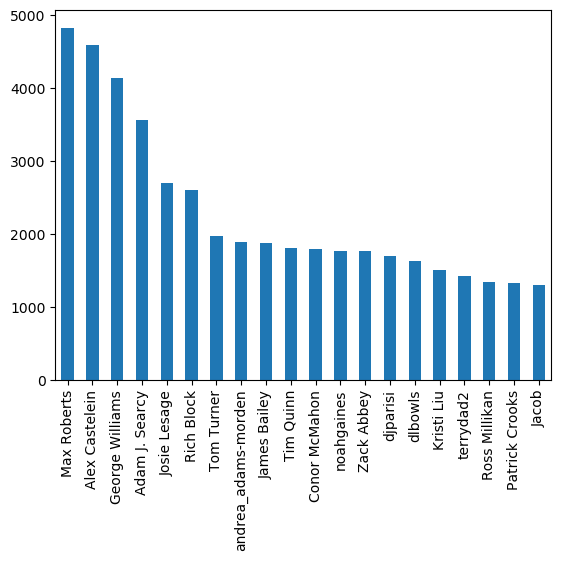

In [33]:
top_rcrds = sb_inat.recordedBy.value_counts()[:20] # count observations for each user and return 20 most active

top_rcrds.plot(kind='bar')

In [24]:
len(sb_inat.recordedBy.unique())

# topusrs = sb_inat.groupby('recordedBy') #group dataframe by users
# topusrs.truncate #truncate to top users by number of observations (>20)
#

# active_recorders = top_re.sort_values('Weather',ascending=False)
# print(sort_by_weather_desc.head(n=3))

141421

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
0,1703218988,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/8964710,Plantae,Tracheophyta,Magnoliopsida,Rosales,Rosaceae,Heteromeles,Heteromeles arbutifolia,...,David Vander Pluym,2017-11-28T16:16:36,CC_BY_NC_4_0,David Vander Pluym,David Vander Pluym,NaN,NaN,2022-11-11T17:31:27.950Z,StillImage;StillImage;StillImage,COORDINATE_ROUNDED
1,2542877676,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/14123375,Plantae,Tracheophyta,Magnoliopsida,Lamiales,Lamiaceae,Trichostema,Trichostema lanatum,...,Krissa Klein,2019-12-31T08:40:45,CC_BY_NC_4_0,dennis1,dennis1,NaN,NaN,2022-11-11T17:31:37.445Z,StillImage;StillImage,COORDINATE_ROUNDED
2,2236229147,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/22100520,Plantae,Tracheophyta,Magnoliopsida,Oxalidales,Oxalidaceae,Oxalis,Oxalis pes-caprae,...,Jim Riley,2019-04-06T17:58:04,CC_BY_NC_4_0,Jim Riley,Jim Riley,NaN,NaN,2022-11-11T17:31:49.498Z,StillImage,COORDINATE_ROUNDED
3,2826332347,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/54560051,Animalia,Arthropoda,Insecta,Hymenoptera,Apidae,Bombus,Bombus vosnesenskii,...,Carlo,2020-07-27T20:03:46,CC_BY_NC_4_0,Carlo,Carlo,NaN,NaN,2022-11-11T17:32:46.231Z,StillImage;StillImage;StillImage;StillImage,COORDINATE_ROUNDED
4,2963805574,50c9509d-22c7-4a22-a47d-8c48425ef4a7,https://www.inaturalist.org/observations/63292703,Animalia,Chordata,Aves,Passeriformes,Laniidae,Lanius,Lanius ludovicianus,...,Dustin Harris,2020-10-23T02:50:46,CC_BY_NC_4_0,Dustin Harris,Dustin Harris,NaN,NaN,2022-11-11T17:33:03.132Z,StillImage;StillImage,COORDINATE_ROUNDED


Using iNaturalist Research - Grade Observations
https://www.gbif.org/dataset/50c9509d-22c7-4a22-a47d-8c48425ef4a7

Help for using the API: https://www.gbif.org/developer/summary



In [ ]:
# Read in your token
#iucn_token="9bb4facb6d23f48efbf424bb05c0c1ef1cf6f468393bc745d42179ac4aca5fee"

# Root URL for GBIF API
gbif_url=" https://api.gbif.org/v1/"

#don't need a token, just your username and password for your GBIF account

In [3]:
from pygbif import species
species.name_suggest(q='Pygoscelis adeliae')

#or look up within the species module using any of these commands:
#species.name_backbone(rank=None, kingdom=None, phylum=None, clazz=None, order=None, family=None, genus=None, strict=False, verbose=False, offset=None, limit=100, **kwargs)


# usrname = "erica-bishop-ucsb"
# password = "p@$$word"

[{'key': 2481663,
  'nameKey': 9561926,
  'kingdom': 'Animalia',
  'phylum': 'Chordata',
  'order': 'Sphenisciformes',
  'family': 'Spheniscidae',
  'genus': 'Pygoscelis',
  'species': 'Pygoscelis adeliae',
  'kingdomKey': 1,
  'phylumKey': 44,
  'classKey': 212,
  'orderKey': 7190978,
  'familyKey': 5284,
  'genusKey': 2481662,
  'speciesKey': 2481663,
  'parent': 'Pygoscelis',
  'parentKey': 2481662,
  'nubKey': 2481663,
  'scientificName': 'Pygoscelis adeliae (Hombron & Jacquinot, 1841)',
  'canonicalName': 'Pygoscelis adeliae',
  'rank': 'SPECIES',
  'status': 'ACCEPTED',
  'synonym': False,
  'higherClassificationMap': {'1': 'Animalia',
   '44': 'Chordata',
   '212': 'Aves',
   '7190978': 'Sphenisciformes',
   '5284': 'Spheniscidae',
   '2481662': 'Pygoscelis'},
  'class': 'Aves'},
 {'key': 10492546,
  'nameKey': 9561933,
  'kingdom': 'incertae sedis',
  'phylum': 'Cossaviricota',
  'order': 'Sepolyvirales',
  'family': 'Polyomaviridae',
  'genus': 'Gammapolyomavirus',
  'species'

In [ ]:
#Lets explore this API investigating penguins!
# Look up names like mammalia
species.name_lookup(q='Spheniscidae')

# Paging
species.name_lookup(q='Spheniscidae', limit=1)
species.name_lookup(q='Spheniscidae', limit=1, offset=2)

# large requests, use offset parameter
first = species.name_lookup(q='Spheniscidae', limit=1000)
second = species.name_lookup(q='Spheniscidae', limit=1000, offset=1000)

# Get all data and parse it, removing descriptions which can be quite long
species.name_lookup('Pygoscelis adeliae', rank="species", verbose=True)

# Get all data and parse it, removing descriptions field which can be quite long
out = species.name_lookup('Pygoscelis adeliae', rank="species")
res = out['results']
[ z.pop('descriptions', None) for z in res ]
res

# Fuzzy searching
# species.name_lookup(q='Heli', rank="genus")

# # Limit records to certain number
# species.name_lookup('Helianthus annuus', rank="species", limit=2)

# # Query by habitat
# species.name_lookup(habitat = "terrestrial", limit=2)
# species.name_lookup(habitat = "marine", limit=2)
# species.name_lookup(habitat = "freshwater", limit=2)

# Using faceting
# species.name_lookup(facet='status', limit=0, facetMincount='70000')
# species.name_lookup(facet=['status', 'higherTaxonKey'], limit=0, facetMincount='700000')

# species.name_lookup(facet='nameType', limit=0)
# species.name_lookup(facet='habitat', limit=0)
# species.name_lookup(facet='datasetKey', limit=0)
# species.name_lookup(facet='rank', limit=0)
# species.name_lookup(facet='isExtinct', limit=0)

# text highlighting
species.name_lookup(q='plant', hl=True, limit=30)

# Lookup by datasetKey
species.name_lookup(datasetKey='3f8a1297-3259-4700-91fc-acc4170b27ce')

In [4]:
test_data_1 = species.name_lookup(institution_code="iNaturalist", q='Pygoscelis adeliae')
test_data_2 = species.name_lookup(q='Pygoscelis adeliae')
test_data_1 == test_data_2

False

In [ ]:
from pygbif import occurrences as occ

In [5]:
type(adelie_iNat)

NameError: name 'adelie_iNat' is not defined

In [ ]:
adelie_data = occ.search(institutionCode="iNaturalist", sp

USE CASE:

In [ ]:
### Use Case: Investigating where the most iNaturalist observations are recorded

Much ecological data, including iNaturalist data, is biased towards recording observations where the observers are, not necessarily where the species are. This means that observations don't necessarily refelect the spatial distribution of species.

In [6]:
test_data_1 = species.name_lookup(institution_code="iNaturalist", q='Pygoscelis adeliae')

In [8]:
type(test_data_1)

test_data_1


{'offset': 0,
 'limit': 100,
 'endOfRecords': True,
 'count': 42,
 'results': [{'key': 123208669,
   'nameKey': 9561924,
   'datasetKey': 'a5dd063e-f45b-4a54-8b94-8fa3adf7f1e1',
   'nubKey': 2481663,
   'parentKey': 167183729,
   'parent': 'Spheniscidae',
   'kingdom': 'Animalia',
   'order': 'Sphenisciformes',
   'family': 'Spheniscidae',
   'species': 'Pygoscelis adeliae',
   'kingdomKey': 167183684,
   'orderKey': 167183728,
   'familyKey': 167183729,
   'speciesKey': 123208669,
   'scientificName': 'Pygoscelis adeliae',
   'canonicalName': 'Pygoscelis adeliae',
   'authorship': '',
   'nameType': 'SCIENTIFIC',
   'taxonomicStatus': 'ACCEPTED',
   'rank': 'SPECIES',
   'origin': 'SOURCE',
   'numDescendants': 0,
   'numOccurrences': 0,
   'habitats': [],
   'nomenclaturalStatus': [],
   'threatStatuses': [],
   'descriptions': [],
   'vernacularNames': [{'vernacularName': 'Adelie Penguin', 'language': 'eng'},
    {'vernacularName': 'Adeliepinguin', 'language': 'deu'},
    {'vernacul

In [15]:
df = pd.DataFrame.from_dict(test_data_1, orient='index') #THIS WORKED!

# test_DF.from_dict(test_data_1, orient='columns')

In [16]:
df.head()

,0
offset,0
limit,100
endOfRecords,True
count,42
results,"[{'key': 123208669, 'nameKey': 9561924, 'datas..."


In [18]:
adelie_iNat = occ.search(institutionCode="iNaturalist", limit=20, )

a
